In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

sns.set_theme()

from evaluation.serialization import Serializer
from constants import KINGDOMS

In [4]:
cv_training_metrics = Serializer.load("cv_training_metrics")
cv_final_metrics = Serializer.load("cv_metrics")
final_training_metrics = Serializer.load("final_training_metrics")
final_metrics = Serializer.load("final_metrics")

In [6]:
with open("../data/kingdom_distribution.pickle", "rb") as f:
    proportions = pickle.load(f)

In [8]:
relevant_data = final_metrics\
    .query("kingdom != 'overall' and label == 'overall'")\
    .groupby(["metric", "label", "kingdom"])\
    .agg(["mean", "std"])\
    .sort_values(by="label")\
    ["value"]

relevant_data["ci"] = 1.96 * relevant_data["std"]

In [10]:
cv_data = cv_final_metrics\
    .query("kingdom != 'overall' and label == 'overall' and metric != 'accuracy'")\
    .groupby(["metric", "label", "kingdom"])\
    .agg(["mean", "std"])\
    .sort_values(by="metric")\
    ["value"]

cv_data["ci"] = 1.96 * cv_data["std"]

In [12]:
relevant_data.query(f"kingdom == 'ARCHAEA'")


,,,mean,std,ci
metric,label,kingdom,,,
mcc,overall,ARCHAEA,0.871662,0.026809,0.052545
precision,overall,ARCHAEA,0.866673,0.042156,0.082626
recall,overall,ARCHAEA,0.853563,0.038346,0.075157


In [11]:
relevant_data.query("metric == 'mcc'")

mean       std        ci
metric label   kingdom                               
mcc    overall ARCHAEA   0.871662  0.026809  0.052545
               EUKARYA   0.900886  0.006853  0.013432
               NEGATIVE  0.880880  0.011438  0.022418
               POSITIVE  0.856922  0.021242  0.041634

# Test Set + CV + random baseline

## Fix baseline values

In [119]:
baseline = pd.read_csv("../data/random_baseline.tsv", sep="\t")
baseline = baseline[baseline["target"] == 'residue_6state'].drop("target", 1).drop("accuracy", 1)

# Insert MCC column with 0.0 values
baseline.insert(2, "mcc", 0.)

# Convert existing value columns to numeric values
baseline[baseline == "None"] = np.NaN
for col in ["precision", "recall"]:
    baseline[col] = pd.to_numeric(baseline[col])

C:\Users\juliu\AppData\Local\Temp/ipykernel_19300/2293192437.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  baseline = baseline[baseline["target"] == 'residue_6state'].drop("target", 1).drop("accuracy", 1)


,kingdom,type,mcc,precision,recall
57,EUKARYA,I,0.0,0.814196,0.814196
58,EUKARYA,L,0.0,NaN,NaN
59,EUKARYA,M,0.0,0.020916,0.020916
60,EUKARYA,O,0.0,0.117804,0.117804
61,EUKARYA,S,0.0,0.047084,0.047084
62,EUKARYA,T,0.0,NaN,NaN


In [23]:
import matplotlib
matplotlib.rcParams.update({"errorbar.capsize": 5})
from colors import final_color, cv_color, baseline_color

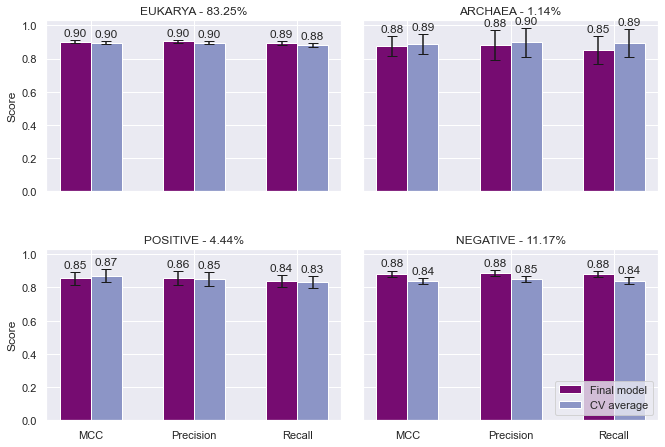

In [28]:
bar_width = 0.3
metrics = ["mcc", "precision", "recall"]
labels = ["MCC", "Precision", "Recall"]
r1 = np.arange(len(metrics))
r2 = r1 + bar_width

fig = plt.figure()
gs = fig.add_gridspec(2, 2)
((ax1, ax2), (ax3, ax4)) = gs.subplots(sharex="col", sharey="row")
for ax, kingdom in zip([ax1, ax2, ax3, ax4], KINGDOMS):
    ax.set_title(f"{kingdom} - {proportions[kingdom]:.2%}")
    final_values = ax.bar(
        r1,
        relevant_data.query(f"kingdom == '{kingdom}'")["mean"],
        yerr=relevant_data.query(f"kingdom == '{kingdom}'")["ci"],
        width=bar_width,
        color=final_color,
        label="Final model"
    )

    cv_values = ax.bar(
        r2,
        cv_data.query(f"kingdom == '{kingdom}'")["mean"],
        yerr=cv_data.query(f"kingdom == '{kingdom}'")["ci"],
        width=bar_width,
        color=cv_color,
        label="CV average"
    )

    ax.set_ylabel("Score")
    ax.set_xticks(r1 + bar_width/2)
    ax.set_xticklabels(labels)
    ax.set_ylim([0.0, 1.03])
    ax.label_outer()

    ax.bar_label(final_values, padding=2, fmt="%.2f")
    ax.bar_label(cv_values, padding=2, fmt="%.2f")

plt.legend(loc="lower right")
fig.tight_layout()
fig.set_size_inches(10, 7)
fig.savefig("output/performance_by_kingdom_vs_cv.png", dpi=240)
